<a href="https://colab.research.google.com/github/vir-malhotra/musicrecommend-playitalsopls/blob/main/Music_Recommender_and_Previewer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is an app combining 3 different music APIs to get a user's top Spotify songs, recommend a song based on their listening history in a specified genre, and previewing a 30-second clip of the recommended song.



Import the requisite libraries

In [24]:
import requests
import webbrowser
from IPython.display import Audio, display

Using Spotify API to generate an authorisation token. One must take care to copy the code from the broken URL (as the redirect URI does not work properly with colab)

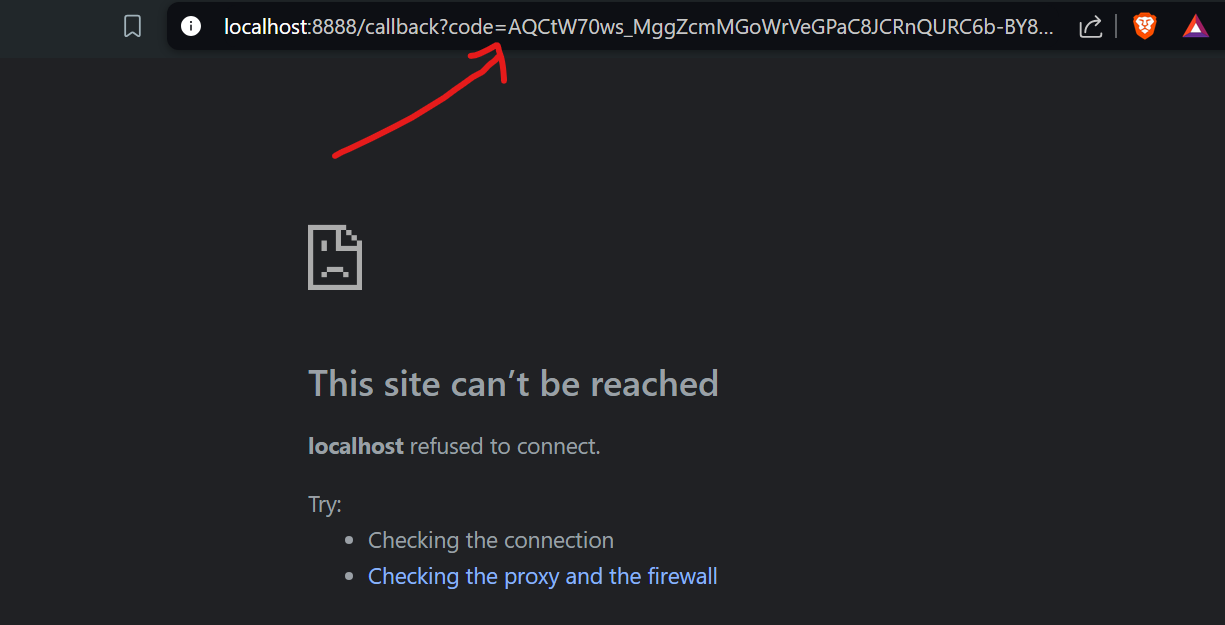

In [ ]:
# Step 1: Generate Spotify authorization URL
def get_authorization_url(client_id, redirect_uri):
    auth_url = (
        f"https://accounts.spotify.com/authorize?client_id={client_id}"
        f"&response_type=code&redirect_uri={redirect_uri}"
        f"&scope=user-read-private%20user-read-email%20user-top-read"
    )
    return auth_url

# Step 2: Exchange Authorization Code for Access Token
def get_access_token(client_id, client_secret, code, redirect_uri):
    token_url = "https://accounts.spotify.com/api/token"
    data = {
        'grant_type': 'authorization_code',
        'code': code,
        'redirect_uri': redirect_uri,
        'client_id': client_id,
        'client_secret': client_secret
    }

    response = requests.post(token_url, data=data)
    token_response_data = response.json()

    if 'access_token' in token_response_data:
        return token_response_data['access_token']
    else:
        print(f"Failed to get access token: {response.status_code}, {response.json()}")
        return None


Use the Spotify API to get the top 5 songs of the user, and then use them to recommend one song. The parameters and limits can be changed to get as many top songs and recommended songs as one likes.

In [26]:
# Spotify API - Get top 5 songs
def get_top_songs(access_token):
    headers = {
        'Authorization': f'Bearer {access_token}',
    }
    params = {
        'limit': 5  # Limit to top 5 songs
    }
    response = requests.get('https://api.spotify.com/v1/me/top/tracks', headers=headers, params=params)

    if response.status_code != 200:
        print(f"Spotify API error: {response.status_code}, {response.json()}")
        return None

    data = response.json()
    songs = [(track['name'], track['artists'][0]['name']) for track in data['items']]  # (song title, artist name)

    return songs

# Spotify API - Get recommended song
def get_spotify_recommendation(access_token, seed_genres):
    headers = {
        'Authorization': f'Bearer {access_token}',
    }
    params = {
        'seed_genres': seed_genres,  # Generate recommendation based on specified genre
        'limit': 1,  # Get a single recommendation
    }
    response = requests.get('https://api.spotify.com/v1/recommendations', headers=headers, params=params)

    if response.status_code != 200:
        print(f"Spotify API error: {response.status_code}, {response.json()}")
        return None

    data = response.json()
    if 'tracks' not in data or len(data['tracks']) == 0:
        print("No tracks found in Spotify recommendation.")
        return None

    return data['tracks'][0]  # Return the first recommended track


Use the Genius API to get a link to the official song lyrics

In [27]:
# Genius API - Fetch song lyrics
def get_genius_lyrics(song_title, artist_name, genius_token):
    headers = {
        'Authorization': f'Bearer {genius_token}',
    }
    params = {
        'q': f'{song_title} {artist_name}',
    }
    response = requests.get('https://api.genius.com/search', headers=headers, params=params)

    if response.status_code != 200:
        print(f"Genius API error: {response.status_code}, {response.json()}")
        return None

    data = response.json()
    if 'response' not in data or 'hits' not in data['response'] or len(data['response']['hits']) == 0:
        print(f"No lyrics found for {song_title} by {artist_name}.")
        return None

    # Extract the first hit's URL
    song_info = data['response']['hits'][0]['result']
    lyrics_url = song_info['url']

    # Fetch lyrics
    response = requests.get(lyrics_url)
    return f"Full lyrics available at: {lyrics_url}"


Use the Deezer API to get a 30-second preview of the recommended song

In [28]:
# Deezer API - Play song preview
def play_song_deezer(song_title, artist_name):
    params = {
        'q': f'{song_title} {artist_name}',
    }
    response = requests.get('https://api.deezer.com/search', params=params)

    if response.status_code != 200:
        print(f"Deezer API error: {response.status_code}, {response.json()}")
        return None

    data = response.json()
    if 'data' not in data or len(data['data']) == 0:
        print(f"No song preview found for {song_title} by {artist_name}.")
        return None

    # Return the preview URL
    return data['data'][0]['preview']


Use the colab library to play the preview in-program.

In [29]:
# Play audio from a URL (30-second preview)
def play_audio_in_colab(url):
    audio_response = requests.get(url)

    with open('preview.mp3', 'wb') as audio_file:
        audio_file.write(audio_response.content)

    display(Audio('preview.mp3'))


Main function that calls the functions and provides the output

In [31]:
def main():
    client_id = '229c1f2251644255b462ce68150e0524'
    client_secret = '46d55a0837024eb284b03c33cec0cc5d'
    redirect_uri = 'http://localhost:8888/callback'  # Doesn't have to be real for manual authorization
    genius_token = 'o3CIRTKT953mhz5dfuRmXA9GGgJxsvIURPBs2t8ouMQZQkm_2GMXOlpWaLTOe9qu'

    auth_url = get_authorization_url(client_id, redirect_uri)
    print(f"Go to the following URL to authorize the app:\n{auth_url}")
    print()
    code = input("Enter the Spotify authorization code from the URL: ")
    print()
    access_token = get_access_token(client_id, client_secret, code, redirect_uri)

    if not access_token:
        print("Failed to get access token.")
        return
    print()
    top_songs = get_top_songs(access_token)
    if top_songs:
        print("Your Top Songs on Spotify:")
        for idx, (song_title, artist_name) in enumerate(top_songs, 1):
            print(f"{idx}. {song_title} by {artist_name}")
    else:
        print("No top songs found.")

    print()

    seed_genres = 'hip-hop'
    song = get_spotify_recommendation(access_token, seed_genres)

    if song:
        song_title = song['name']
        artist_name = song['artists'][0]['name']

        print(f"Recommended Song: {song_title} by {artist_name}")
        print()
        lyrics_text = get_genius_lyrics(song_title, artist_name, genius_token)
        if lyrics_text:
            print(f"Lyrics: {lyrics_text}")
        print()
        deezer_preview_url = play_song_deezer(song_title, artist_name)
        if deezer_preview_url:
            print(f"Playing 30-second preview...")
            print()
            play_audio_in_colab(deezer_preview_url)
        else:
            print("No song recommendation available.")

if __name__ == "__main__":
    main()


Go to the following URL to authorize the app:
https://accounts.spotify.com/authorize?client_id=229c1f2251644255b462ce68150e0524&response_type=code&redirect_uri=http://localhost:8888/callback&scope=user-read-private%20user-read-email%20user-top-read

Enter the Spotify authorization code from the URL: AQCeeWzg5F7-w65zDsc4_M2G9zENQKKqtMsasZur_RMIjg73husV3V_kFMTbP1cjanuhjAEr6gJ8HX0TGQAb8TWin9TgJcu1I_Iw39VBe58PHTrO68lGFrRyh-zzwRHGIDyMb9hVchfUE29gDV0Pwoo_5J9atLxoaW5FRT9NpbPKtUJ77VEC8R487LsdOzs0pR3LD85NPd9VJNLu9bYVRysmuKdlA1uW9d_GvhPRlA0ZpVAD4Q


Your Top Songs on Spotify:
1. KALI by Biicla
2. senses by april27
3. Chakkar by tricksingh
4. hmu by greek
5. not too late by heartaake

Recommended Song: Switch Lanes by Tyga

Lyrics: Full lyrics available at: https://genius.com/Tyga-switch-lanes-lyrics

Playing 30-second preview...

